## 1. Download the dataset

In [1]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

## 2. Preprocess the dataset
    - Split the dataset into training : validation = 0.9 : 0.1
    - Normalization and transform the dataset into PyTorch tensor use torchvision.transforms

In [2]:

ROOT = './data'
train_data = datasets.MNIST(
    root=ROOT,
    train=True,
    download=True
)

test_data = datasets.MNIST(
    root=ROOT,
    train=False,
    download=True
)

VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(
    train_data,
    [n_train_examples, n_valid_examples]
)

# compute mean and std of the training data for normalization
mean = train_data.dataset.data.float().mean() / 255
std = train_data.dataset.data.float().std() / 255

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

train_data.dataset.transform = train_transforms
valid_data.dataset.transform = test_transforms

# Create dataloader
BATCH_SIZE = 256

train_dataloader = data.DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE
)

valid_dataloader = data.DataLoader(
    valid_data,
    batch_size=BATCH_SIZE
)

## 3. Build the LeNet model

In [3]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding='same')
        self.avgpool1 =nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16*5*5, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

## 4. Train the model

In [4]:
import time

def train(model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()

    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        predictions = model(inputs)

        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())

        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                f"| epoch {epoch:3d} | {idx:5d}/{len(train_dataloader):5d} batches "
                f"| accuracy {total_acc / total_count:8.3f}"
            )
            total_acc, total_count = 0, 0
            start_time = time.time()

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)

    return epoch_acc, epoch_loss

# Evaluation function
def evaluate(model, criterion, valid_dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []

    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            predictions = model(inputs)

            loss = criterion(predictions, labels)
            losses.append(loss.item())

            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)

    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)

    return epoch_acc, epoch_loss


In [6]:
num_classes = len(train_data.dataset.classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(lenet_model.parameters())

num_epochs = 10
save_model = './model'

train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

for epoch in range(1, num_epochs+1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(lenet_model, optimizer, criterion, train_dataloader, device, epoch)
    train_accs.append(train_acc)
    train_losses.append(train_loss)

    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)

    # Save the best model
    if eval_loss < best_loss_eval:
        torch.save(lenet_model.state_dict(), save_model + '/mnist_lenet_model.pt')

    # Print loss, acc end epoch
    print('-'*60)
    print(
        f"| End of epoch {epoch:3d} | Time: {time.time() - epoch_start_time:5.2f}s "
        f"| Train Accuracy {train_acc:8.3f} | Train Loss {train_loss:8.3f} "
        f"| Valid Accuracy {eval_acc:8.3f} | Valid Loss {eval_loss:8.3f} "
    )
    print('-'*60)

    # Load best model
    lenet_model.load_state_dict(torch.load(save_model+'/mnist_lenet_model.pt'))
    lenet_model.eval()


| epoch   1 |    50/  211 batches | accuracy    0.645
| epoch   1 |   100/  211 batches | accuracy    0.897
| epoch   1 |   150/  211 batches | accuracy    0.934
| epoch   1 |   200/  211 batches | accuracy    0.951
------------------------------------------------------------
| End of epoch   1 | Time: 33.66s | Train Accuracy    0.961 | Train Loss    0.500 | Valid Accuracy    0.957 | Valid Loss    0.151 
------------------------------------------------------------
| epoch   2 |    50/  211 batches | accuracy    0.961
| epoch   2 |   100/  211 batches | accuracy    0.963
| epoch   2 |   150/  211 batches | accuracy    0.968
| epoch   2 |   200/  211 batches | accuracy    0.971
------------------------------------------------------------
| End of epoch   2 | Time: 33.00s | Train Accuracy    0.978 | Train Loss    0.114 | Valid Accuracy    0.969 | Valid Loss    0.104 
------------------------------------------------------------
| epoch   3 |    50/  211 batches | accuracy    0.975
| epoch 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


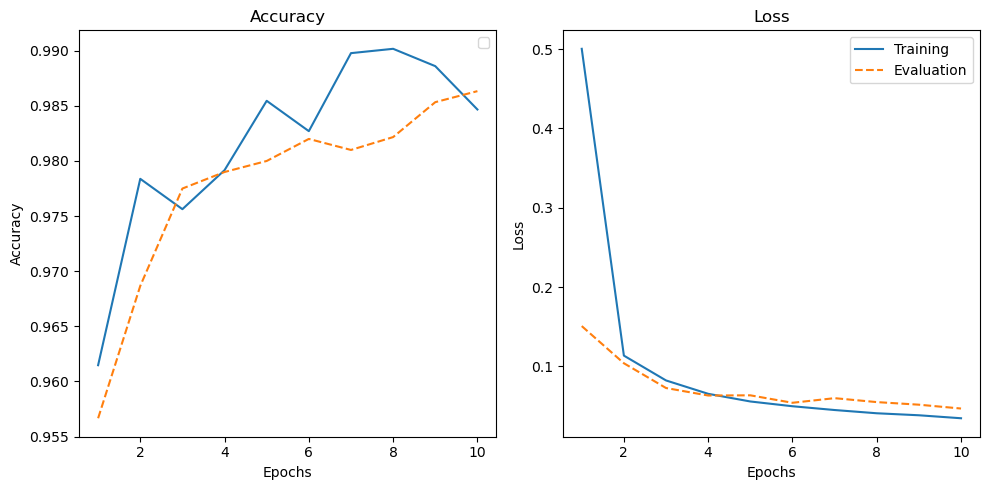

In [7]:
epochs = range(1, num_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Accuracy
axes[0].plot(epochs, train_accs, linestyle='-')
axes[0].plot(epochs, eval_accs, linestyle='--')
axes[0].set_title("Accuracy")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend()

# Loss
axes[1].plot(epochs, train_losses, label="Training", linestyle='-')
axes[1].plot(epochs, eval_losses, label="Evaluation", linestyle='--')
axes[1].set_title("Loss")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show();

In [ ]:
test_data.transform = test_transforms
test_dataloader = data.DataLoader(
                                test_data ,
                                batch_size=BATCH_SIZE)
test_acc , test_loss = evaluate(lenet_model , criterion , test_dataloader)
test_acc , test_loss

(0.9861, 0.04300383265217533)